In [1]:
import os
import numpy as np
import mne
from matplotlib import pyplot as plt
from matplotlib.pyplot import MultipleLocator
import pandas as pd
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from copy import deepcopy
from mne.preprocessing import create_ecg_epochs, create_eog_epochs, read_ica
import sys
from langouEEG import *

S11


C:\MatlabWorkspace\langouEEG.py:68: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(file_path, preload=True)


Reading 0 ... 1562349  =      0.000 ...  3124.698 secs...
1 duplicate electrode labels found:
M1/Trigger
Plotting 66 unique labels.
Creating RawArray with float64 data, n_channels=66, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


C:\MatlabWorkspace\langouEEG.py:68: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_cnt(file_path, preload=True)
C:\MatlabWorkspace\langouEEG.py:84: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne.viz.plot_montage(layout)


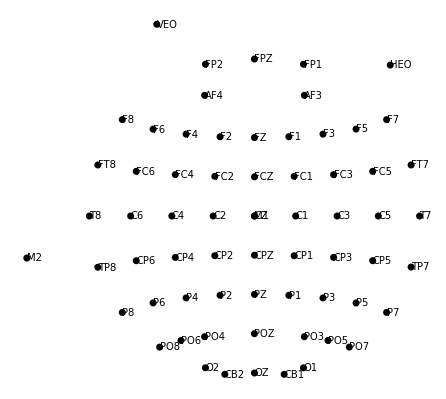

file info:
<Info | 10 non-empty values
 bads: 1 items (Trigger)
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 66 EEG
 custom_ref_applied: False
 dig: 66 items (66 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: []
 sfreq: 500.0 Hz
 subject_info: 5 items (dict)
>
channel names:
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'Trigger']
time period:
1562350
events:
Used Annotations descriptions: ['11', '12', '8', '9']
{'random_flicker-60s': 1, 'random_rest-300s': 2, '40Hz_rest-300s': 3, '40Hz_flicker-60s': 4}
Filtering raw data in 1 contiguous seg

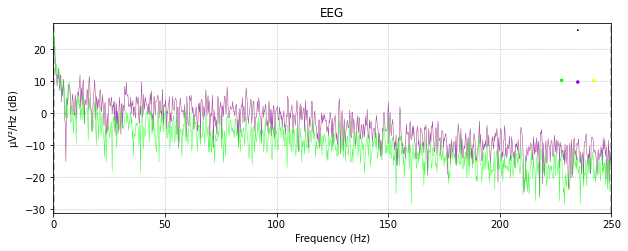

Fitting ICA to data using 65 channels (please be patient, this may take a while)


C:\MatlabWorkspace\langouEEG.py:124: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=20, random_state=0)


Selecting by number: 20 components


In [ ]:
init_prog()
for i in range(11,12):
    if i<10:
        subject_name='S0'+str(i)
    else:
        subject_name='S'+str(i)
    print(subject_name)
    raw,picks,picks_str = initData(subject_name)
    initLayout(raw)
    events, event_dict=extractEvents(raw)
    filterRaw(raw, picks, ref_set_average=False, ref_channels=['M1', 'M2'])
    runICA(raw)
    epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochs(raw,events,picks)
    epochs = epoch_RR,epoch_RF,epoch_4R,epoch_4F
    downstream_mean_power,target_mean_power,upstream_mean_power=getRatio_rest(epoch_4R,picks=picks_str, MA = True)
    downstream_mean_power,target_mean_power,upstream_mean_power=getRatio_flicker(epoch_4F,picks=picks_str, MA = True)
    specPlot(epochs, MA = True)
    superposGamma(epoch_4R,epoch_4F,epoch_RF,subject_name)
    superposFull(epoch_4R,epoch_4F,epoch_RF,subject_name)
    print(subject_name+'done')
save_ratios()
csv_transformat(type='flicker')
csv_transformat(type='rest')

In [ ]:
subject_name='S11'
raw,picks,picks_str = initData(subject_name)
initLayout(raw)
events, event_dict=extractEvents(raw)
filterRaw(raw, picks, ref_set_average=False, ref_channels=['M1', 'M2'])
runICA(raw)
epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochs(raw,events,picks)
epochs = epoch_RR,epoch_RF,epoch_4R,epoch_4F
downstream_mean_power,target_mean_power,upstream_mean_power=getRatio_rest(epoch_4R,picks=picks_str)
downstream_mean_power,target_mean_power,upstream_mean_power=getRatio_flicker(epoch_4F,picks=picks_str)
specPlot(epochs)
superposGamma(epoch_4R,epoch_4F,epoch_RF,subject_name)
superposFull(epoch_4R,epoch_4F,epoch_RF,subject_name)

In [ ]:
psds, freqs = psd_multitaper(epoch_4F,fmin=35, fmax=45, n_jobs=8,picks=picks_str) 
superposGamma(epoch_4R,epoch_4F,epoch_RF,subject_name)

In [ ]:
psds.shape

In [ ]:
def MA(psds):
    n=20.0
    for i in range(psds.shape[0]):
        tempSum=0
        for j in range(int(n)):
            if j+i < psds.shape[0]:
                tempSum+=psds[j+i]
            else:
                n=j
                break
        psds[i]=tempSum/n
    return psds

In [ ]:
def plot_psd_sub(epoch,ax, fmin=.1, fmax=100, n_jobs=8, color='k', alpha=.5, label='Default'):
    psds, freqs = psd_multitaper(epoch, fmin=fmin, fmax=fmax, n_jobs=n_jobs)
    psds = 10. * np.log10(psds)
    psds_mean = psds.mean(0).mean(0)
    psds_std = psds.mean(0).std(0)
    print(psds_std.shape)
    ax.plot(freqs, MA(psds_mean), color=color, label = label)
    ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color=color, alpha=alpha)
    ax.legend()
def MA(psds):
    n=20.0
    for i in range(psds.shape[0]):
        tempSum=0
        for j in range(int(n)):
            if j+i < psds.shape[0]:
                tempSum+=psds[j+i]
            else:
                n=j
                break
        psds[i]=tempSum/n
    return psds
fmin = 0
fmax = 120
alpha = .2
f, ax = plt.subplots(figsize=(25,10))
plot_psd_sub(ax=ax,epoch = epoch_4R, color='y', fmin=fmin, fmax=fmax, alpha=alpha, label='Rest State')
plot_psd_sub(ax=ax,epoch = epoch_4F, color='k', fmin=fmin, fmax=fmax, alpha=alpha, label='40 Hz Light Stimulation')
plot_psd_sub(ax=ax,epoch = epoch_RF, color='r', fmin=fmin, fmax=fmax, alpha=alpha, label='Random Hz Light Stimulation')
plt.xlabel("Frequency")
plt.ylabel("Power spectral density (PSD) in log")